In [3]:
# 引入相关库
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# from pandas import datetime
import math, time
import itertools
from sklearn import preprocessing
import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers import LSTM
from keras.models import load_model
import keras
import pandas_datareader.data as web
import h5py
from keras.callbacks import EarlyStopping, ModelCheckpoint

plt.style.use('fivethirtyeight')

In [4]:
# 导入数据
# dataset = './data/BTC.csv'
# dataset.head()
# training_set = dataset[:'2017'].iloc[:,3:4].values
# test_set = dataset['2018':].iloc[:,3:4].values
# training_set

            Date     BTC Open     BTC High      BTC Low    BTC Close  \
0     2015/11/15   333.050995   334.661987   317.489990   320.165985   
1     2015/11/16   319.734985   331.626007   315.904999   330.751007   
2     2015/11/17   330.362000   338.350006   329.614014   335.093994   
3     2015/11/18   334.592987   336.531006   330.640015   334.589996   
4     2015/11/19   334.678986   335.334015   325.273010   326.148987   
...          ...          ...          ...          ...          ...   
1573    2020/3/6  9078.308594  9167.695313  9032.079102  9122.545898   
1574    2020/3/7  9121.600586  9163.220703  8890.744141  8909.954102   
1575    2020/3/8  8908.206055  8914.343750  8105.252930  8108.116211   
1576    2020/3/9  8111.146484  8177.793457  7690.098145  7923.644531   
1577   2020/3/10  7922.146973  8136.945313  7814.763184  7909.729492   

       BTC Volume   ETH Price  XRP Price  LTC Price  Oil price  Gold Price  \
0        44213100    0.906368   0.004165   3.082256      

C:\Users\MSI-PC\AppData\Local\Temp\ipykernel_4188\2541925105.py:8: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr('kendall')


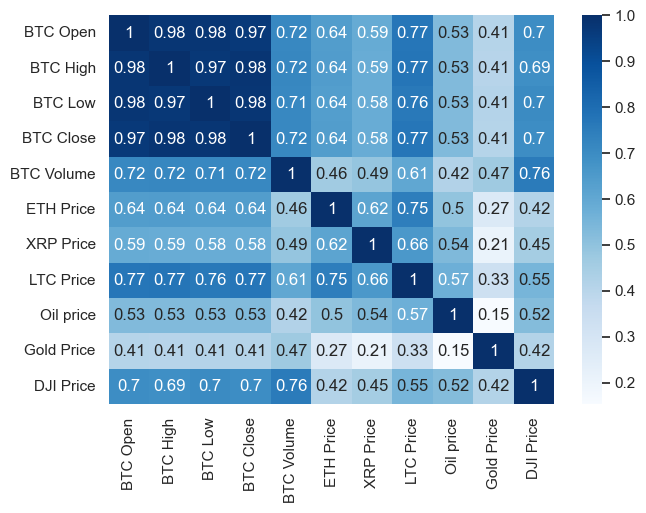

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split

# 读取DataFrame数据集
df = pd.read_csv("./data/init_data.csv")
print(df)
# print(df.to_string())
corr_matrix = df.corr('kendall')
print(corr_matrix)
import seaborn as sns
import matplotlib.pyplot as plt
 
 
sns.set(font_scale=1.0)
sns.heatmap(corr_matrix, cmap="Blues", annot=True, xticklabels=corr_matrix.columns, yticklabels=corr_matrix.columns)
plt.show()


In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split

# 读取DataFrame数据集
df = pd.read_csv("./data/init_data.csv")

# 计算分割点
split_point = int(0.9 * len(df))

# 将DataFrame数据集分成训练集和测试集
train_df = df.iloc[:split_point, :]
test_df = df.iloc[split_point:, :]

# 将train_df和test_df的Date列转换为datetime格式，并作为索引
train_df["Date"] = pd.to_datetime(train_df["Date"])
train_df.set_index("Date", inplace=True)
test_df["Date"] = pd.to_datetime(test_df["Date"])
test_df.set_index("Date", inplace=True)

# 输出训练集和测试集的大小
print("Training set size:", len(train_df))
print("Testing set size:", len(test_df))
test_df

Training set size: 1420
Testing set size: 158


C:\Users\MSI-PC\AppData\Local\Temp\ipykernel_4188\3731884262.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["Date"] = pd.to_datetime(train_df["Date"])
C:\Users\MSI-PC\AppData\Local\Temp\ipykernel_4188\3731884262.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["Date"] = pd.to_datetime(test_df["Date"])


,BTC Open,BTC High,BTC Low,BTC Close,BTC Volume,ETH Price,XRP Price,LTC Price,Oil price,Gold Price,DJI Price
Date,,,,,,,,,,,
2019-10-05,8210.149414,8215.526367,8071.120605,8151.500488,12200497197,176.351517,0.251875,56.409874,52.79,1510.07,26541.82
2019-10-06,8149.876953,8161.410156,7958.850586,7988.155762,13160830305,173.059143,0.253063,56.755123,52.77,1507.23,26509.92
2019-10-07,7989.120605,8308.450195,7905.766113,8245.623047,18009742607,181.186340,0.254292,54.568078,52.75,1504.40,26478.02
2019-10-08,8246.849609,8332.714844,8185.763184,8228.783203,15592264032,182.021561,0.274047,57.510842,52.63,1503.90,26164.04
2019-10-09,8229.840820,8627.706055,8169.298828,8595.740234,19384942333,193.293259,0.276886,57.003822,52.59,1512.80,26346.01
...,...,...,...,...,...,...,...,...,...,...,...
2020-03-06,9078.308594,9167.695313,9032.079102,9122.545898,40826885650,243.525299,0.237999,61.647478,41.28,1672.40,25864.78
2020-03-07,9121.600586,9163.220703,8890.744141,8909.954102,36216930369,237.853088,0.243868,63.123118,37.90,1673.50,25193.53
2020-03-08,8908.206055,8914.343750,8105.252930,8108.116211,39973102120,200.689056,0.237092,60.431705,34.51,1674.60,24522.27


<Figure size 1000x2000 with 0 Axes>

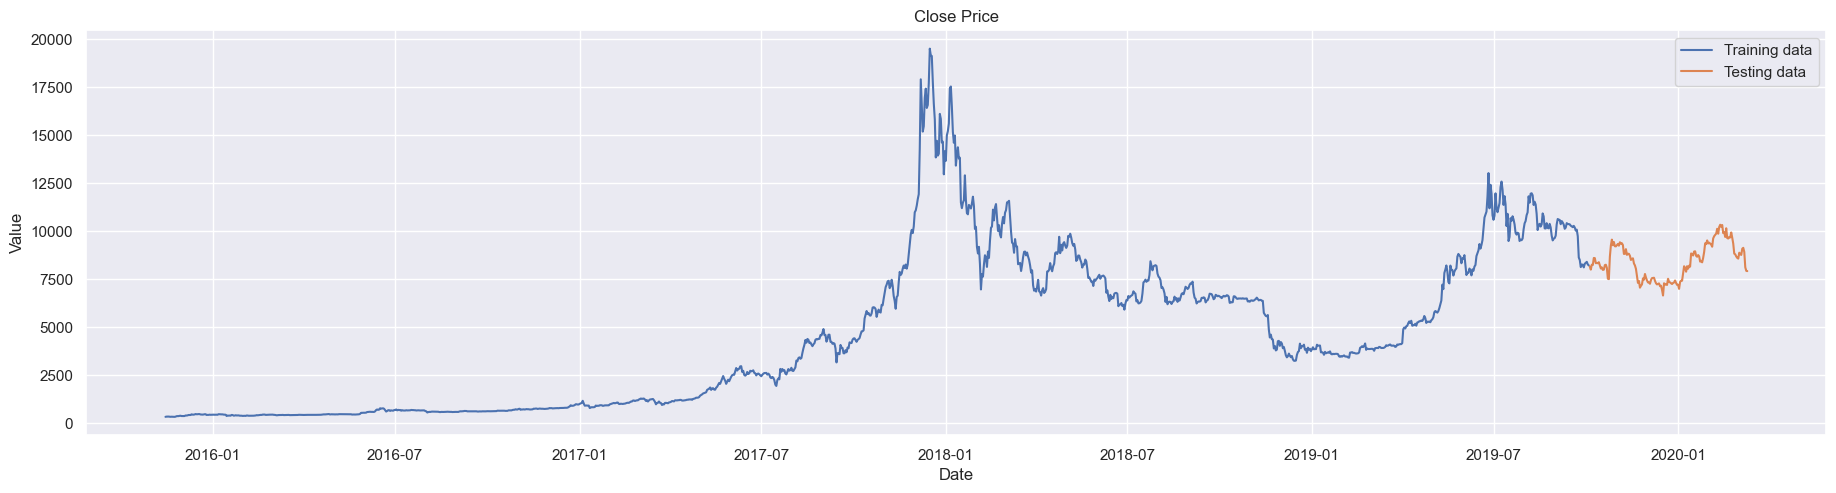

In [7]:
# 绘制训练集中每一列的图表
fig = plt.figure(figsize=(10, 20))

# 绘制训练集中A列的图表
fig, ax = plt.subplots(figsize=(20,5))
ax.plot(train_df["BTC Close"], label="Training data")

# 绘制测试集中A列的图表
ax.plot(test_df["BTC Close"], label="Testing data")

# 设置图表标题和轴标签
ax.set_title("Close Price")
ax.set_xlabel("Date")
ax.set_ylabel("Value")

# 添加图例
ax.legend()

# 显示图表
plt.show()

In [29]:
seq_len = 5
d = 0.2
shape = [11, seq_len, 1] # feature, window, output
neurons = [128, 128, 32, 1]
epochs = 100

In [30]:
# 如果不添加这句，是无法直接在jupyter里看到图的
import seaborn as sns
sns.set(style="darkgrid")
df

,BTC Open,BTC High,BTC Low,BTC Close,BTC Volume,ETH Price,XRP Price,LTC Price,Oil price,Gold Price,DJI Price
Date,,,,,,,,,,,
2015-11-15,0.000695,0.000587,0.000283,0.000006,0.000412,0.000082,0.000023,0.000236,0.309363,0.054226,0.131222
2015-11-16,0.000000,0.000433,0.000198,0.000558,0.000487,0.000098,0.000026,0.000591,0.309363,0.054226,0.131222
2015-11-17,0.000555,0.000774,0.000932,0.000785,0.000547,0.000155,0.000048,0.000598,0.288048,0.030303,0.131689
2015-11-18,0.000776,0.000682,0.000987,0.000758,0.000404,0.000144,0.000052,0.000612,0.289641,0.030463,0.149517
2015-11-19,0.000780,0.000621,0.000700,0.000318,0.000428,0.000117,0.000041,0.000369,0.285458,0.045136,0.149200
...,...,...,...,...,...,...,...,...,...,...,...
2020-03-06,0.457222,0.447469,0.467255,0.459005,0.809647,0.173924,0.068912,0.163980,0.300199,0.993301,0.734607
2020-03-07,0.459482,0.447242,0.459682,0.447919,0.718173,0.169860,0.070641,0.168106,0.232869,0.995056,0.686285
2020-03-08,0.448342,0.434651,0.417591,0.406108,0.792705,0.143231,0.068645,0.160581,0.165339,0.996810,0.637962


In [31]:
# 归一化
def get_stock_data(normalize=True):
    df = pd.read_csv('./data/init_data.csv', index_col='Date', parse_dates=['Date'])
    min_max_scaler = preprocessing.MinMaxScaler()
    df['BTC Open'] = min_max_scaler.fit_transform(df['BTC Open'].values.reshape(-1,1))
    df['BTC High'] = min_max_scaler.fit_transform(df['BTC High'].values.reshape(-1,1))
    df['BTC Low'] = min_max_scaler.fit_transform(df['BTC Low'].values.reshape(-1,1))
    df['BTC Close'] = min_max_scaler.fit_transform(df['BTC Close'].values.reshape(-1,1))
    df['BTC Volume'] = min_max_scaler.fit_transform(df['BTC Volume'].values.reshape(-1,1))
    df['ETH Price'] = min_max_scaler.fit_transform(df['ETH Price'].values.reshape(-1,1))
    df['XRP Price'] = min_max_scaler.fit_transform(df['XRP Price'].values.reshape(-1,1))
    df['LTC Price'] = min_max_scaler.fit_transform(df['LTC Price'].values.reshape(-1,1))
    df['Oil price'] = min_max_scaler.fit_transform(df['Oil price'].values.reshape(-1,1))
    df['Gold Price'] = min_max_scaler.fit_transform(df['Gold Price'].values.reshape(-1,1))
    df['DJI Price'] = min_max_scaler.fit_transform(df['DJI Price'].values.reshape(-1,1))
    return df
 
df = get_stock_data(normalize=True)
df

,BTC Open,BTC High,BTC Low,BTC Close,BTC Volume,ETH Price,XRP Price,LTC Price,Oil price,Gold Price,DJI Price
Date,,,,,,,,,,,
2015-11-15,0.000695,0.000587,0.000283,0.000006,0.000412,0.000082,0.000023,0.000236,0.309363,0.054226,0.131222
2015-11-16,0.000000,0.000433,0.000198,0.000558,0.000487,0.000098,0.000026,0.000591,0.309363,0.054226,0.131222
2015-11-17,0.000555,0.000774,0.000932,0.000785,0.000547,0.000155,0.000048,0.000598,0.288048,0.030303,0.131689
2015-11-18,0.000776,0.000682,0.000987,0.000758,0.000404,0.000144,0.000052,0.000612,0.289641,0.030463,0.149517
2015-11-19,0.000780,0.000621,0.000700,0.000318,0.000428,0.000117,0.000041,0.000369,0.285458,0.045136,0.149200
...,...,...,...,...,...,...,...,...,...,...,...
2020-03-06,0.457222,0.447469,0.467255,0.459005,0.809647,0.173924,0.068912,0.163980,0.300199,0.993301,0.734607
2020-03-07,0.459482,0.447242,0.459682,0.447919,0.718173,0.169860,0.070641,0.168106,0.232869,0.995056,0.686285
2020-03-08,0.448342,0.434651,0.417591,0.406108,0.792705,0.143231,0.068645,0.160581,0.165339,0.996810,0.637962


            BTC Open  BTC High   BTC Low  BTC Close  BTC Volume  ETH Price  \
Date                                                                         
2015-11-15  0.000695  0.000587  0.000283   0.000006    0.000412   0.000082   
2015-11-16  0.000000  0.000433  0.000198   0.000558    0.000487   0.000098   
2015-11-17  0.000555  0.000774  0.000932   0.000785    0.000547   0.000155   
2015-11-18  0.000776  0.000682  0.000987   0.000758    0.000404   0.000144   
2015-11-19  0.000780  0.000621  0.000700   0.000318    0.000428   0.000117   

            XRP Price  LTC Price  Oil price  Gold Price  DJI Price  
Date                                                                
2015-11-15   0.000023   0.000236   0.309363    0.054226   0.131222  
2015-11-16   0.000026   0.000591   0.309363    0.054226   0.131222  
2015-11-17   0.000048   0.000598   0.288048    0.030303   0.131689  
2015-11-18   0.000052   0.000612   0.289641    0.030463   0.149517  
2015-11-19   0.000041   0.000369   0.28

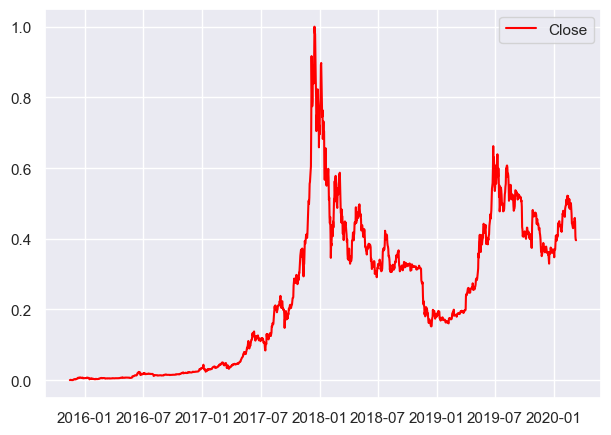

In [32]:
# 绘制正则化后的标签数据
df = get_stock_data(normalize=True)
print(df.head())
plt.plot(df['BTC Close'], color='red', label='Close')
plt.legend(loc='best')
plt.show()

In [33]:
# 把最后一天的 Close作为y值
def load_data(stock, seq_len):
    amount_of_features = len(stock.columns)
    data = stock.values
    sequence_length = seq_len + 1 # index starting from 0
    result = []
    print(data.shape)
                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
    for index in range(len(data) - sequence_length): # maxmimum date = lastest date - sequence length
        result.append(data[index: index + sequence_length]) # index : index + 22days
    
    result = np.array(result)
    row = round(0.9 * result.shape[0]) # 90% split   1580条数据*0.9
    train = result[:int(row), :] # 90% date
#     X_train = train[:, :-1]
#     y_train = train[:,-1][:,4] #close price
    X_train = train[:, :-1] # all data until day m
    
    y_train = train[:, -1][:,-8] # day m + 1 adjusted close price
    print('train.shape:', train.shape)
    print('train.shape:', train[:, -1].shape)
    print('x_train.shape:',X_train.shape, 'yshape:', y_train.shape)
#     X_test = result[int(row):, :-1]
#     y_test = result[int(row):,4]
    X_test = result[int(row):, :-1]
    y_test = result[int(row):, -1][:,-8] 
 
    # print(result)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], amount_of_features))
    print('Xx_train,shape', X_train.shape)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], amount_of_features))  
 
    return [X_train, y_train, X_test, y_test]
 
X_train, y_train, X_test, y_test = load_data(df, seq_len)
# X_test

(1578, 11)
train.shape: (1415, 6, 11)
train.shape: (1415, 11)
x_train.shape: (1415, 5, 11) yshape: (1415,)
Xx_train,shape (1415, 5, 11)


<Figure size 1000x2000 with 0 Axes>

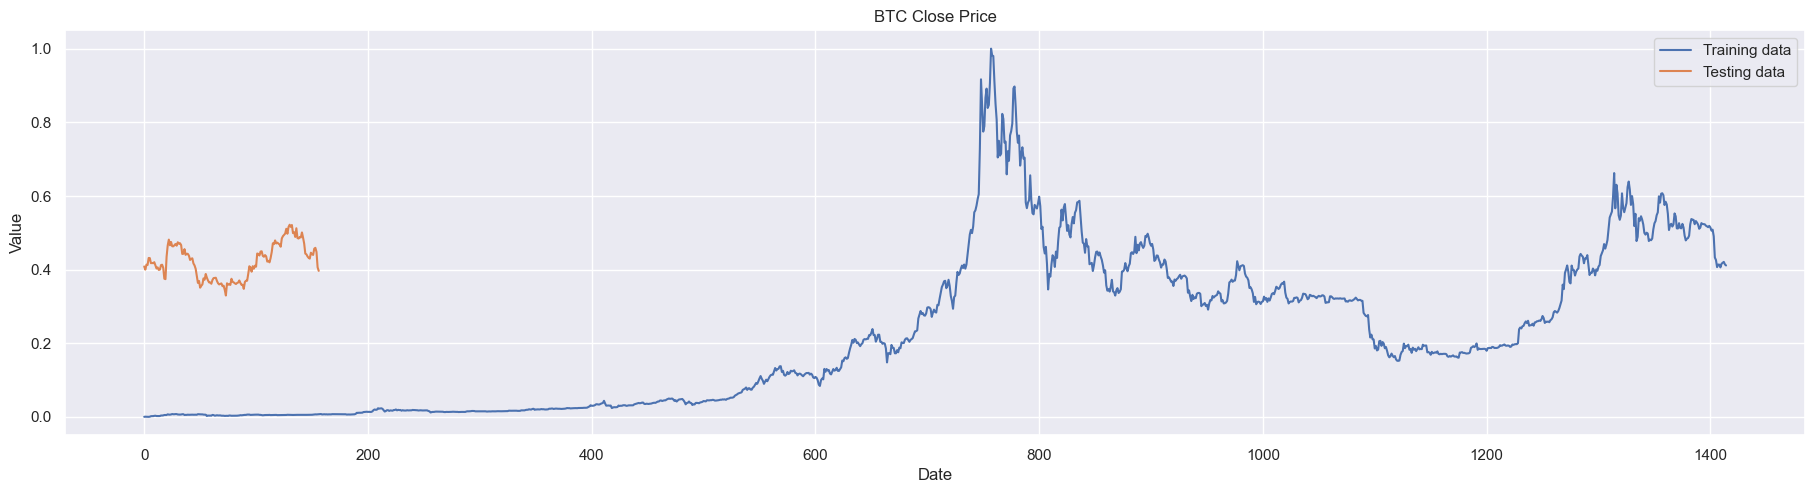

In [34]:
# 绘制训练集中每一列的图表
fig = plt.figure(figsize=(10, 20))

# 绘制训练集中A列的图表
fig, ax = plt.subplots(figsize=(20,5))
ax.plot(y_train, label="Training data")

# 绘制测试集中A列的图表
ax.plot(y_test, label="Testing data")

# 设置图表标题和轴标签
ax.set_title("BTC Close Price")
ax.set_xlabel("Date")
ax.set_ylabel("Value")

# 添加图例
ax.legend()

# 显示图表
plt.show()

In [36]:
# seq_len = 5
# d = 0.2
# shape = [11, seq_len, 1] # feature, window, output
# neurons = [128, 128, 32, 1]
# epochs = 100

def build_model2(layers, neurons, d):
    model = Sequential()
    
    model.add(LSTM(neurons[0], input_shape=(layers[1], layers[0]), return_sequences=True))
    model.add(Dropout(d))
        
    model.add(LSTM(neurons[1], input_shape=(layers[1], layers[2]), return_sequences=False))
    model.add(Dropout(d))
        
    model.add(Dense(neurons[2],kernel_initializer="uniform",activation='relu'))        
    model.add(Dense(neurons[3],kernel_initializer="uniform",activation='linear'))
    # model = load_model('my_LSTM_stock_model1000.h5')
    adam = keras.optimizers.Adam(decay=0.2)
    model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model
 
model = build_model2(shape, neurons, d)


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 5, 128)            71680     
                                                                 
 dropout_18 (Dropout)        (None, 5, 128)            0         
                                                                 
 lstm_19 (LSTM)              (None, 128)               131584    
                                                                 
 dropout_19 (Dropout)        (None, 128)               0         
                                                                 
 dense_18 (Dense)            (None, 32)                4128      
                                                                 
 dense_19 (Dense)            (None, 1)                 33        
                                                                 
Total params: 207,425
Trainable params: 207,425
Non-tr

In [14]:
history=model.fit(
    X_train,
    y_train,
    batch_size=72,
    epochs=300,
    validation_split=0.1,
    verbose=1)

Epoch 1/300
18/18 [==============================] - 3s 52ms/step - loss: 0.0423 - accuracy: 7.8555e-04 - val_loss: 0.0086 - val_accuracy: 0.0000e+00
Epoch 2/300
18/18 [==============================] - 0s 14ms/step - loss: 0.0085 - accuracy: 7.8555e-04 - val_loss: 0.0046 - val_accuracy: 0.0000e+00
Epoch 3/300
18/18 [==============================] - 0s 12ms/step - loss: 0.0025 - accuracy: 0.0016 - val_loss: 0.0100 - val_accuracy: 0.0000e+00
Epoch 4/300
18/18 [==============================] - 0s 13ms/step - loss: 0.0019 - accuracy: 0.0016 - val_loss: 0.0048 - val_accuracy: 0.0000e+00
Epoch 5/300
18/18 [==============================] - 0s 12ms/step - loss: 0.0017 - accuracy: 0.0016 - val_loss: 0.0036 - val_accuracy: 0.0000e+00
Epoch 6/300
18/18 [==============================] - 0s 12ms/step - loss: 0.0013 - accuracy: 0.0016 - val_loss: 0.0017 - val_accuracy: 0.0000e+00
Epoch 7/300
18/18 [==============================] - 0s 13ms/step - loss: 0.0011 - accuracy: 0.0016 - val_loss: 0.00

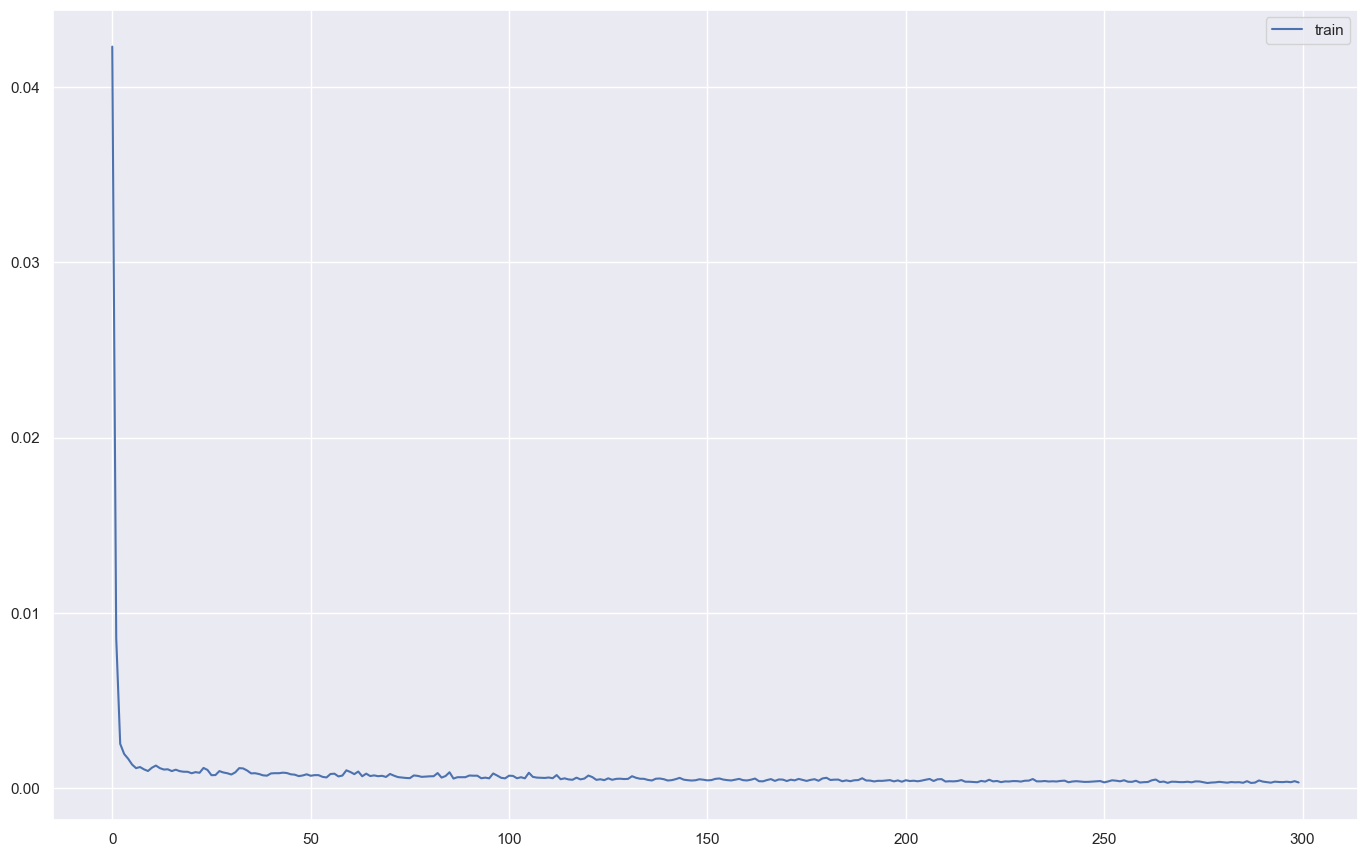

In [15]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(15, 10))
plt.plot(history.history['loss'], label='train')
# plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()
# pd.DataFrame(history.history['loss']).to_csv('./lose.csv')


In [16]:
def model_score(model, X_train, y_train, X_test, y_test):
    trainScore = model.evaluate(X_train, y_train, verbose=0)
    print('Train Score: %.5f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))
 
    testScore = model.evaluate(X_test, y_test, verbose=0)
    print('Test Score: %.5f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))
    return trainScore[0], testScore[0]
 
model_score(model, X_train, y_train, X_test, y_test)

Train Score: 0.00036 MSE (0.02 RMSE)
Test Score: 0.00067 MSE (0.03 RMSE)


(0.00035852318978868425, 0.0006719539524056017)

In [17]:
# 可视化预测结果
def percentage_difference(model, X_test, y_test):
    percentage_diff=[]
 
    p = model.predict(X_test)
    for u in range(len(y_test)): # for each data index in test data
        pr = p[u][0] # pr = prediction on day u
 
        percentage_diff.append((pr-y_test[u]/pr)*100)
    return p

p = percentage_difference(model, X_test, y_test)

5/5 [==============================] - 0s 3ms/step


In [18]:
# 反归一化
def denormalize(normalized_value):
    df = pd.read_csv('./data/BTC.csv', index_col='Date', parse_dates=['Date'])
    
    df = df['Close'].values.reshape(-1,1)
    normalized_value = normalized_value.reshape(-1,1)
    
    #return df.shape, p.shape
    min_max_scaler = preprocessing.MinMaxScaler()
    a = min_max_scaler.fit_transform(df)
    new = min_max_scaler.inverse_transform(normalized_value)
    return new

In [19]:
plt.style.use('fivethirtyeight')
def plot_result(normalized_value_p, normalized_value_y_test):
#     p反归一化
    newp = denormalize(normalized_value_p)
#     test 返归一化
    newy_test = denormalize(normalized_value_y_test)
                            
    plt.figure(figsize=(25, 6))
    plt.plot(newp, color='red', label='Prediction')
    pd.DataFrame(newp).to_csv('./result1.csv')
    
    plt.plot(newy_test,color='blue', label='Actual')
    plt.legend(loc='best')
    plt.title('BTC Price Prediction')
    plt.xlabel('Days')
    plt.ylabel('BTC Price')
    plt.show()

# pd.DataFrame(history.history['loss']).to_csv('./lose.csv')

plot_result(p, y_test)
newp = denormalize(p)

FileNotFoundError: [Errno 2] No such file or directory: './data/BTC.csv'

In [ ]:
# 以 预测准确率=（预测正确样本数）/（总测试样本数）* 100% 对预测准确率进行计算，设定 ErrorTolerance = 5%
def accuracy(predict, true):
    sizeofall = len(true)
    sizeofright = 0
    for i in range(0, sizeofall):
        est = abs(predict[i] - true[i]) / true[i]
        if est < 0.05:
            sizeofright = sizeofright + 1

    return sizeofright/sizeofall

In [ ]:
# y_test
# 将预测准确率打印出来
# predict = np.array(predicted_stock_price)
# true = np.array(test_set)
Ac = accuracy(p, y_test)
print("Accuracy=", Ac*100, '%')

Accuracy= 52.86624203821656 %


In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn import metrics
# 打印MAPE
MAPE = metrics.mean_absolute_percentage_error(p, y_test)
print("MAPE=", MAPE*100, '%')

MAPE= 5.70259100967272 %


NameError: name 'tf' is not defined